<a href="https://colab.research.google.com/github/Njuii/Machine-Learning-Projects-for-Certification/blob/main/Copy_of_fcc_predict_health_costs_with_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries. You may or may not use all of these.
!pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

from tensorflow.keras.layers.experimental import preprocessing
from sklearn.preprocessing import LabelEncoder

  Preparing metadata (setup.py) ... done
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
# Import data
!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
dataset = pd.read_csv('insurance.csv')
dataset.tail()

--2023-04-24 09:59:32--  https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 172.67.70.149, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50264 (49K) [text/csv]
Saving to: ‘insurance.csv.4’

insurance.csv.4     100%[===================>]  49.09K  --.-KB/s    in 0.008s  

2023-04-24 09:59:32 (5.77 MB/s) - ‘insurance.csv.4’ saved [50264/50264]



,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


In [ ]:
# Cleaning data
# Converting categoirical data to numbers

dataset['sex'].replace(['male','female'],[0,1], inplace = True)
dataset['smoker'].replace(['no','yes'],[0,1], inplace = True)
dataset['region'].replace(['southeast', 'northwest', 'southwest','northeast'], [0,1,2,3], inplace = True)

dataset.tail()

,age,sex,bmi,children,smoker,region,expenses
1333,50,0,31.0,3,0,1,10600.55
1334,18,1,31.9,0,0,3,2205.98
1335,18,1,36.9,0,0,0,1629.83
1336,21,1,25.8,0,0,2,2007.95
1337,61,1,29.1,0,1,1,29141.36


In [ ]:
# Train and test datasets (8:2 ratio)
# Could have used df.sample() rather than manually calculating
# train_dataset = dataset[0:1071]
# test_dataset = dataset[1071:]
train_dataset = dataset.sample(frac=0.8)
test_dataset = dataset.sample(frac=0.2)
test_dataset.tail()

,age,sex,bmi,children,smoker,region,expenses
22,18,0,34.1,0,0,0,1137.01
225,55,0,33.9,3,0,0,11987.17
183,44,1,26.4,0,0,1,7419.48
134,20,1,28.8,0,0,3,2457.21
1031,55,1,35.2,0,1,0,44423.80


In [ ]:
# Train and test labels 
train_labels = train_dataset.pop('expenses')
test_labels = test_dataset.pop('expenses')

test_labels.tail()

22       1137.01
225     11987.17
183      7419.48
134      2457.21
1031    44423.80
Name: expenses, dtype: float64

In [ ]:
# Converting labels to DataFrames
train_labels = pd.DataFrame(train_labels)
test_labels = pd.DataFrame(test_labels)
test_labels.tail()

,expenses
22,1137.01
225,11987.17
183,7419.48
134,2457.21
1031,44423.80


In [ ]:
# Describing data
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.00,27.0000,39.00,51.000,64.00
sex,1338.0,0.494768,0.500160,0.00,0.0000,0.00,1.000,1.00
bmi,1338.0,30.665471,6.098382,16.00,26.3000,30.40,34.700,53.10
children,1338.0,1.094918,1.205493,0.00,0.0000,1.00,2.000,5.00
smoker,1338.0,0.204783,0.403694,0.00,0.0000,0.00,0.000,1.00
region,1338.0,1.455157,1.130197,0.00,0.0000,1.00,2.000,3.00
expenses,1338.0,13270.422414,12110.011240,1121.87,4740.2875,9382.03,16639.915,63770.43


In [ ]:
# Model 
# Normalization Layer
normalizer = layers.Normalization(axis = -1)
# Fitting to data 
normalizer.adapt(np.array(train_dataset))
print(normalizer.mean.numpy())


[[39.316814    0.48691595 30.82542     1.071028    0.2         1.4710281 ]]


In [ ]:
from tensorflow.python import train
# Rest of Layers
model = keras.Sequential([
    normalizer,
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(units=1)
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_5 (Normalizat  (None, 6)                13        
 ion)                                                            
                                                                 
 dense_9 (Dense)             (None, 64)                448       
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,686
Trainable params: 4,673
Non-trainable params: 13
_________________________________________________________________


In [ ]:
# Configure Model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error',
    metrics = ['mae','mse']
)

In [ ]:
# Train Model
history = model.fit(
    train_dataset,
    train_labels,
    epochs = 100,
    validation_split = 0.2,
)


9/9 - 0s - loss: 1701.1029 - mae: 1701.1029 - mse: 18989732.0000 - 39ms/epoch - 4ms/step
Testing set Mean Abs Error: 1701.10 expenses
You passed the challenge. Great job!
9/9 [==============================] - 0s 2ms/step


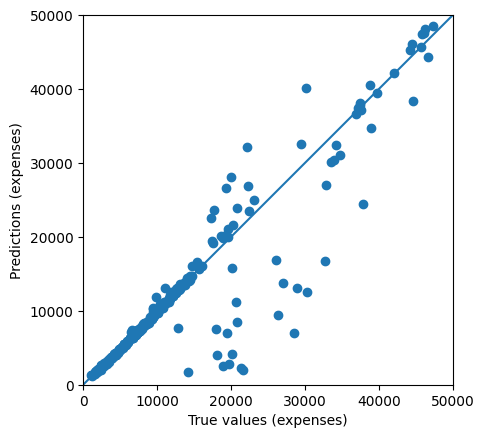

In [ ]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
